# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

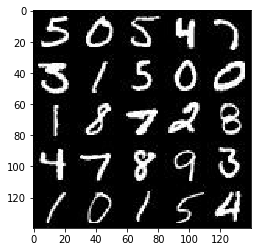

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

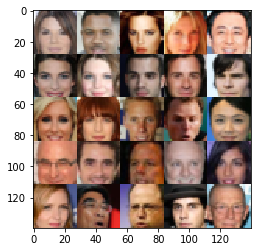

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.09):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
       
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        #14*14
        x2 =tf.layers.conv2d(x1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        #7*7
        x3 =tf.layers.conv2d(x2,256,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
       
        #4*4
        flat = tf.reshape(x3, (-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.09):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.09
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training =is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        #4*4*512
        #https://github.com/tensorflow/tensorflow/issues/2118
        x2 = tf.layers.conv2d_transpose(x1,256,4,strides=1,padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        #7*7*256
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3,128,5,strides=2,padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #14*14*128
        #logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same')
        logits = tf.layers.conv2d_transpose(x4,out_channel_dim,5,strides=1,padding='same')
        out = tf.tanh(logits)
       
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.09):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    fake_images = generator(input_z, out_channel_dim, is_train=True,alpha=alpha)
    real_out, real_logit = discriminator(input_real,reuse=False,alpha=alpha)
    fake_out, fake_logit = discriminator(fake_images,reuse=True,alpha=alpha)
    
    smooth = 0.1
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logit, 
                                                        labels=tf.ones_like(real_logit) * (1. - smooth)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit, 
                                                        labels=tf.zeros_like(real_logit)))
    
    d_loss = d_real_loss + d_fake_loss
    
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit, 
                                                        labels=tf.ones_like(fake_logit)))
        
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,alpha=0.09):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    image_channels = 1
    if data_image_mode == 'RGB':
        image_channels = 3
        
    input_real, input_z,lr = model_inputs(data_shape[1], data_shape[2],image_channels,z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,image_channels,alpha)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1., 1., size=(batch_size,z_dim)) 
                
               
                # Run optimizers
                # https://github.com/soumith/ganhacks
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
              
                
                if steps % 50 == 0:
                    # At the end of each batch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:  batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                steps = steps + 1
      
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.3849... Generator Loss: 0.0075


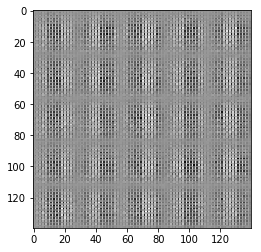

Epoch 1/2... Discriminator Loss: 2.5874... Generator Loss: 0.2488
Epoch 1/2... Discriminator Loss: 1.9163... Generator Loss: 0.5092


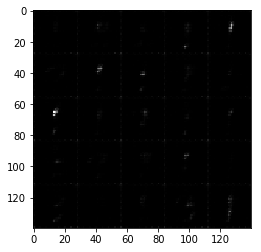

Epoch 1/2... Discriminator Loss: 1.6583... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.6557


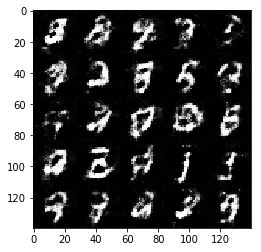

Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.4193


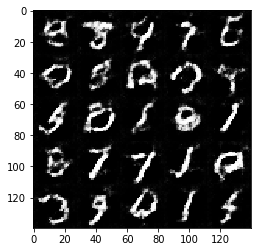

Epoch 1/2... Discriminator Loss: 1.5524... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.4400


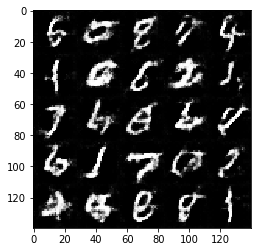

Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.5479


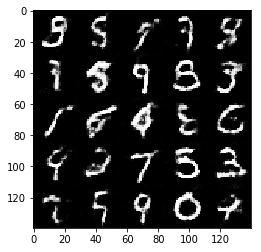

Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.3888


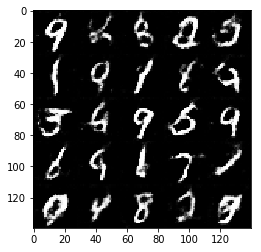

Epoch 1/2... Discriminator Loss: 1.5554... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.6780


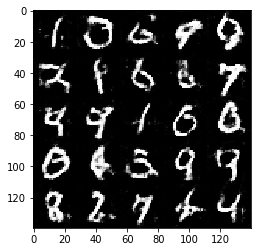

Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.3426
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.6953


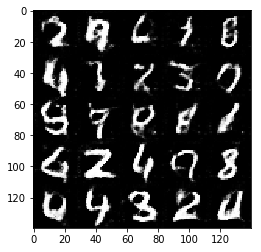

Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.7188


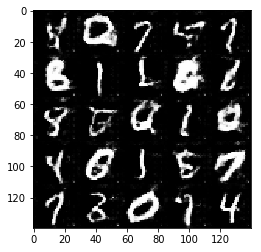

Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.4638
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.4070


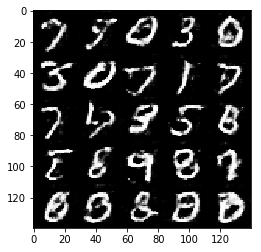

Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.5080


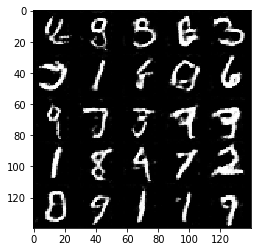

Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.7147


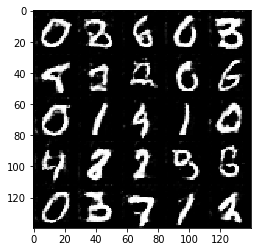

Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.7749


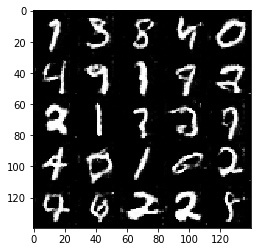

Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 1.4053
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.7597


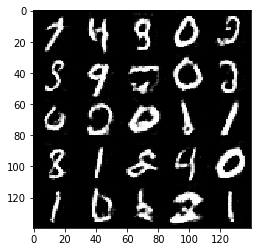

Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.5541
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.5896


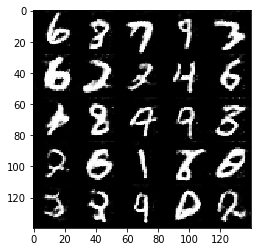

Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.3899


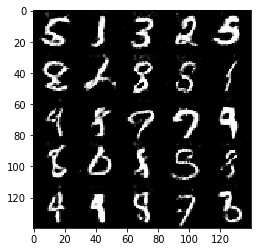

Epoch 1/2... Discriminator Loss: 1.5362... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.4246


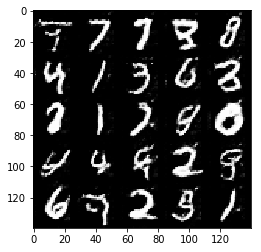

Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.6560


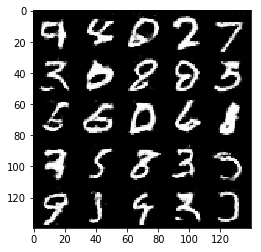

Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.7909


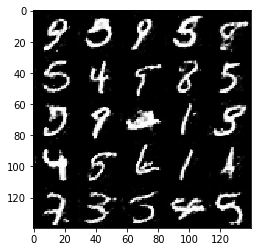

Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.7178


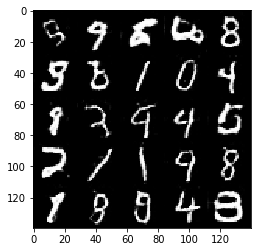

Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 0.4297


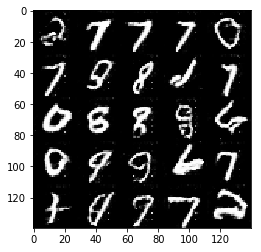

Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.4641... Generator Loss: 0.4875


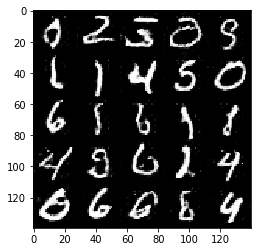

Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.5404
Epoch 2/2... Discriminator Loss: 1.5707... Generator Loss: 1.2306


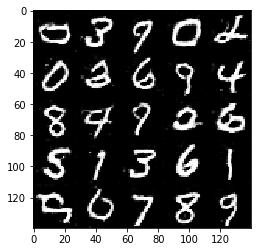

Epoch 2/2... Discriminator Loss: 1.6078... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 0.4725


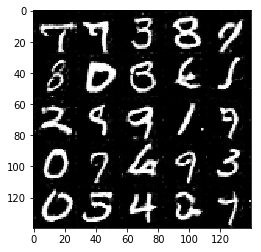

Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.6721


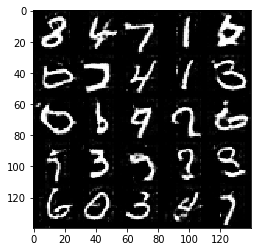

Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.5713


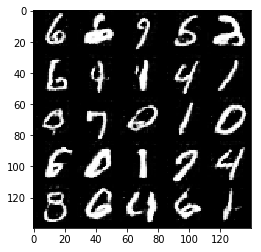

Epoch 2/2... Discriminator Loss: 1.6217... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 1.2494


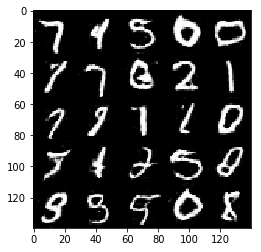

Epoch 2/2... Discriminator Loss: 1.4443... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 0.9925


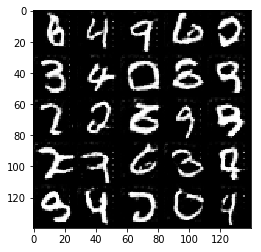

Epoch 2/2... Discriminator Loss: 1.5622... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 1.1419


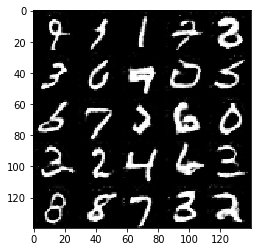

Epoch 2/2... Discriminator Loss: 1.6035... Generator Loss: 0.3881
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.8333


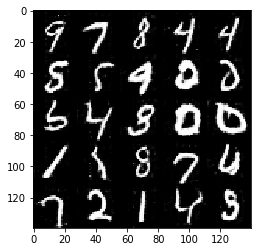

Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.9903
Epoch 2/2... Discriminator Loss: 1.6095... Generator Loss: 0.3719


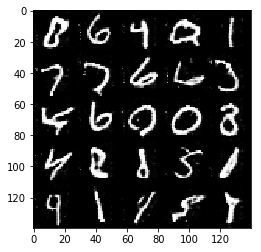

Epoch 2/2... Discriminator Loss: 1.4656... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.6237


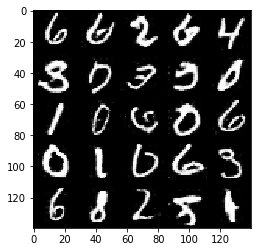

Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.6092


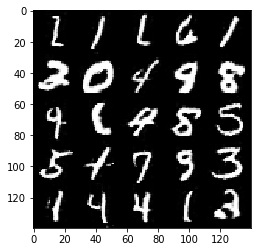

Epoch 2/2... Discriminator Loss: 1.5333... Generator Loss: 0.4235
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.6858


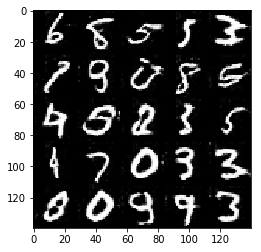

Epoch 2/2... Discriminator Loss: 1.7436... Generator Loss: 0.3344
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.7863


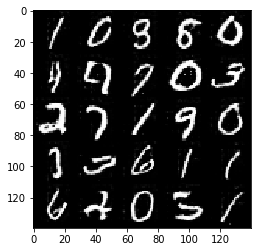

Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.5960


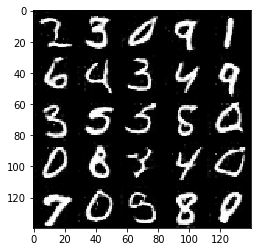

Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 1.6496... Generator Loss: 1.3433


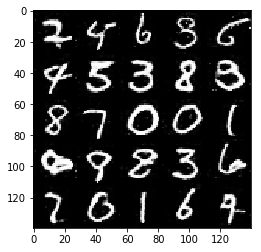

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3
alpha = 0.08

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 15.3003... Generator Loss: 0.0000


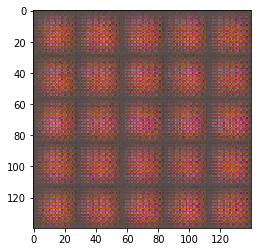

Epoch 1/1... Discriminator Loss: 1.9958... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.9480


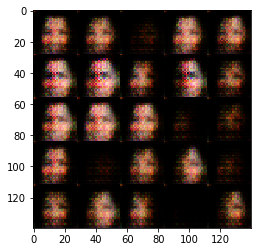

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8112


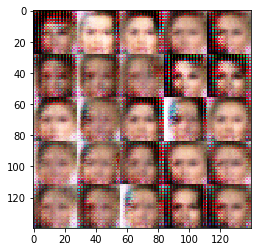

Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7134


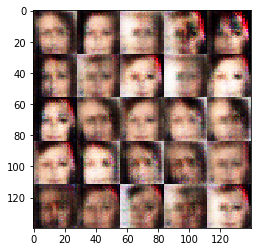

Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7201


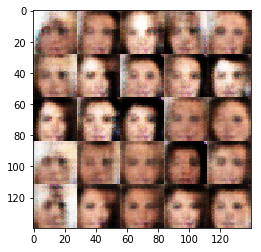

Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7039


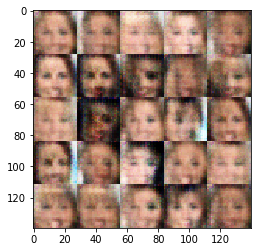

Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7015


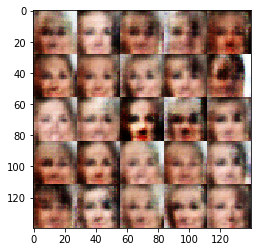

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7271


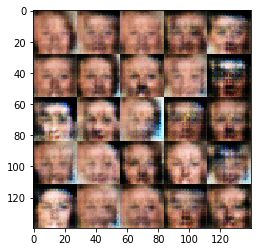

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6639


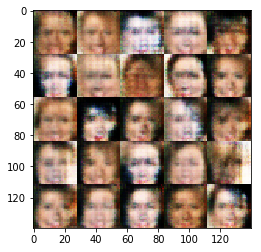

Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7274


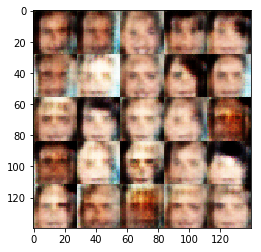

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.9078


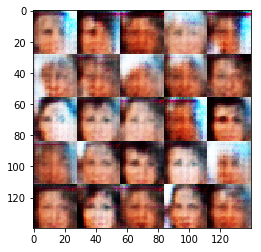

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6176


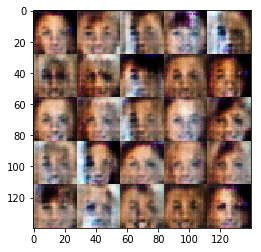

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7350


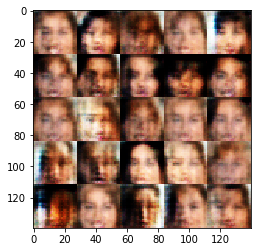

Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5683


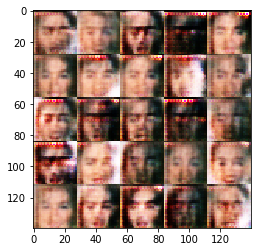

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6745


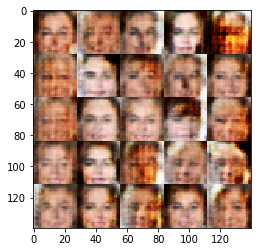

Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8165


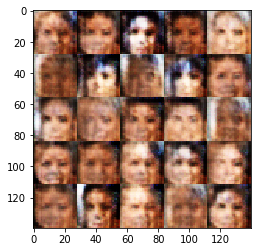

Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8049


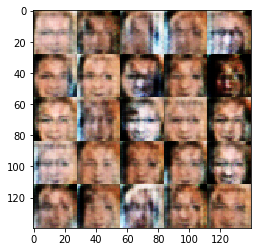

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7699


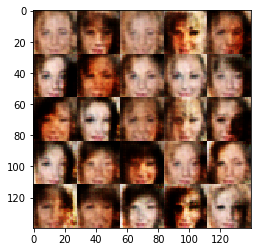

Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7570


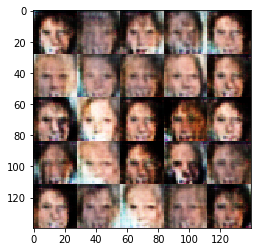

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7227


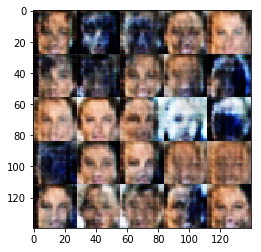

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7180


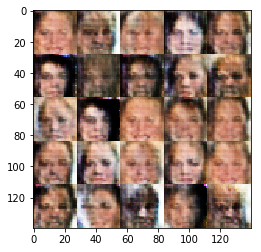

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7048


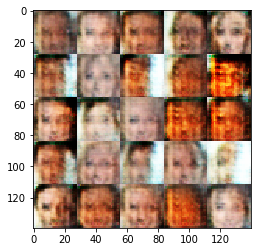

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7920


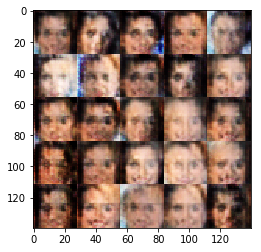

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8679


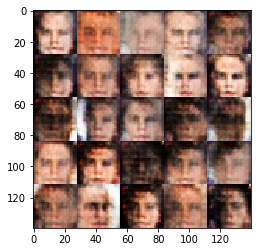

Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7843


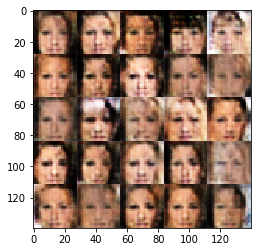

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7251


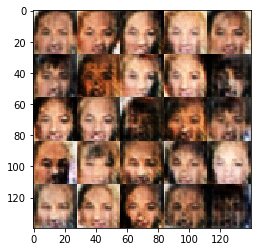

Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.5826


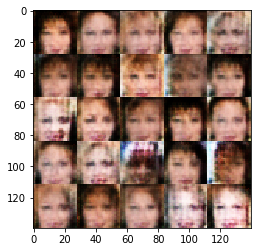

Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8315


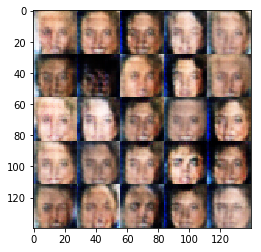

Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7153


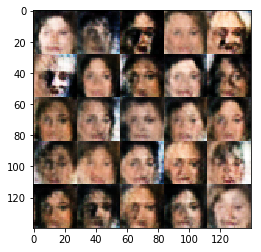

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8157


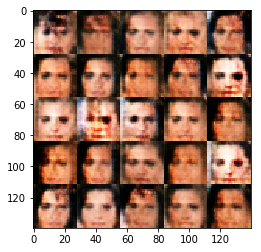

Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7809


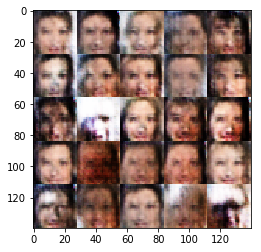

Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8831


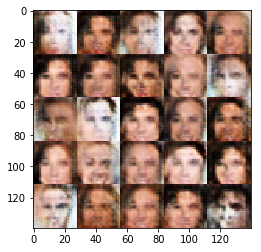

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7457


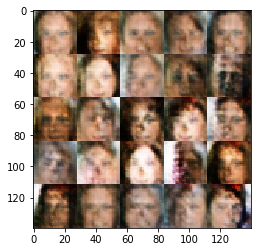

Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7417


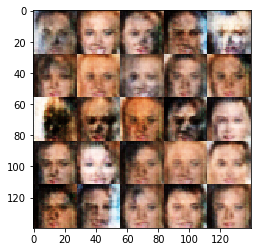

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8144


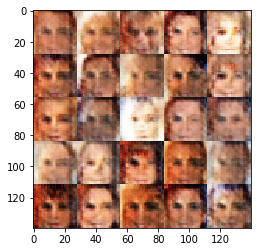

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8336


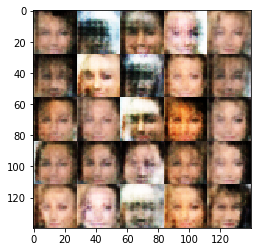

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7999


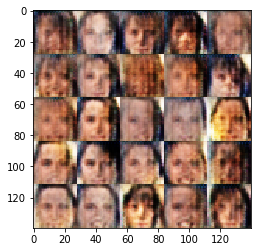

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8206


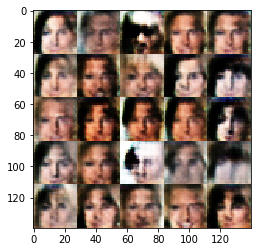

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7669


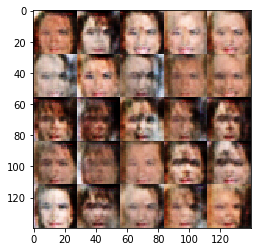

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7396


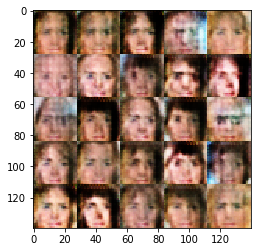

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7552


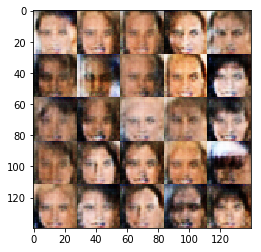

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8319


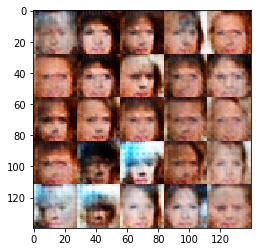

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7603


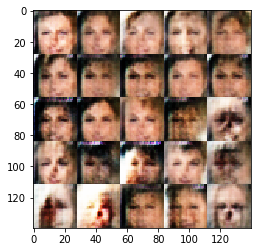

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8120


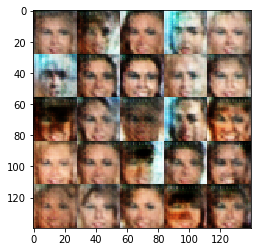

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.7915


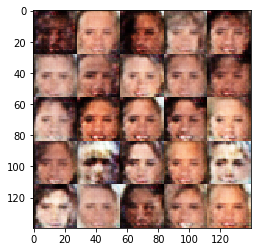

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7776


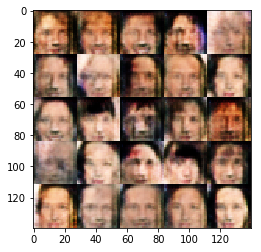

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8025


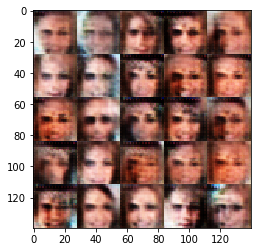

Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 2.1162... Generator Loss: 0.2249


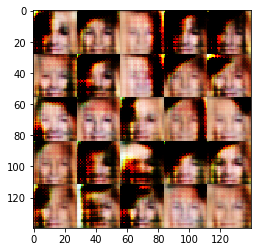

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 1.0061


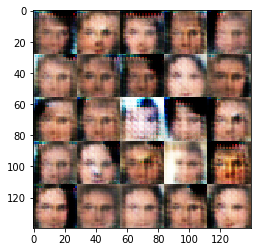

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7079


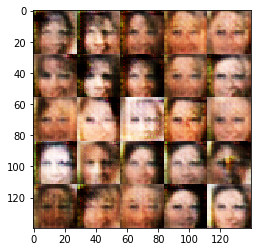

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.8202


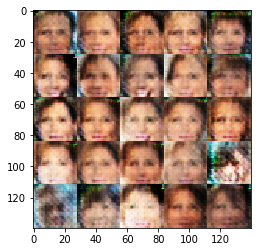

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8201


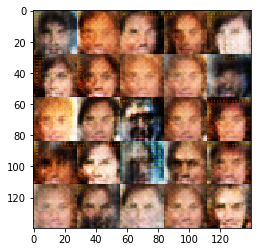

Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7842


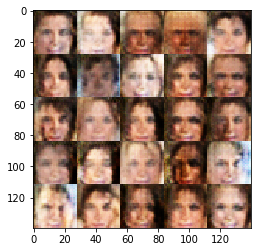

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7827


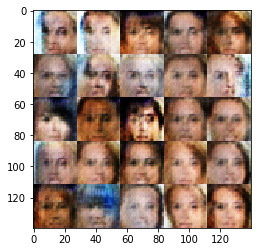

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.8140


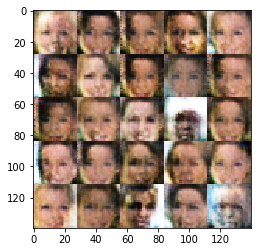

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7602


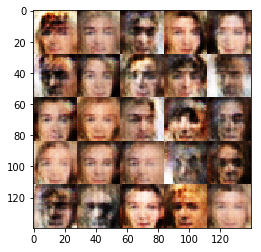

Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8417


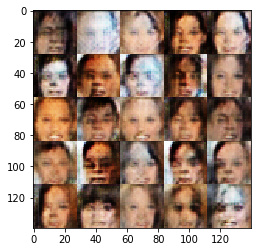

Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7930


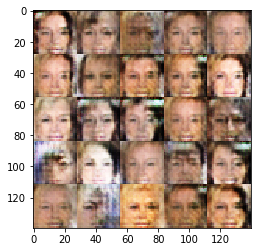

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8870


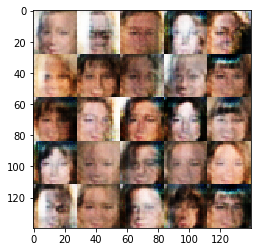

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7667


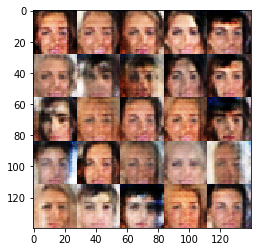

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7908


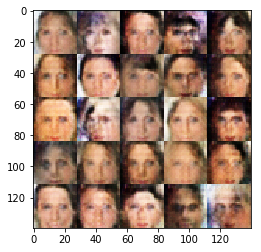

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7964


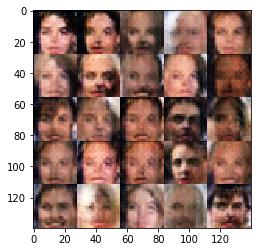

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7445


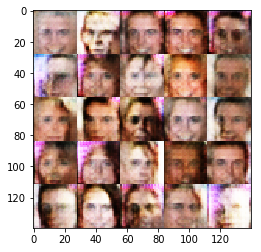

Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6078


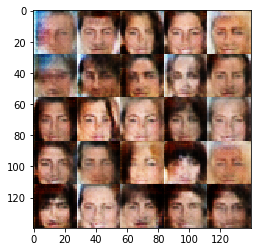

In [37]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.3
alpha =0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.